# NDVI profiles


* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

## Background

## Description

The goal of this notebook is to get the NDVI time series for a collection of points of interest.

---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import gc
import os
import pickle
import pprint

import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS, Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from random_sampling import random_sampling
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:40143 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `vector_file`: file path for the shapefile containing the points of interest.
* `time` : This is the time period of interest to load data for.
* `resolution` : The spatial resolution, in metres, to resample the satellite data to.
* `output_crs` : The coordinate reference system that the loaded data is to be reprojected to.
* `dask_chunks`: the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000).
* `output_dir` : The directory in which to store results from the analysis.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
#vector_file = "../data/boundary_data/donnees_commune_kiota.geojson"
vector_file = "../data/boundary_data/donnees_commune_koygolo.geojson"

# File name to use when exporting results. 
#file_name = "donnees_commune_kiota"
file_name = "donnees_commune_koygolo"

# Time period of interest.
time = "2020"

# Resolution and CRS to reproject data to.
resolution = (-20, 20)
output_crs = "EPSG:6933"

# Size of dask chunks.
dask_chunks = {"time": 1, "x": 500, "y": 500}

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data. 
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="ndvi_profiles")

### Load the shapefile

This shapefile contains the points of interest.

In [5]:
# Read in the vector_file.
gdf = gpd.read_file(vector_file)
# Drop unnecessary columns from the GeoDataFrame.
#gdf = gdf.drop(columns=["VILLAGE", "LATITUDE", "LONGITUD", "ANNEE", "LATDD", "LATMIN", "LAT", "LONDD", "LONMIN", "LON"])
gdf = gdf.drop(columns=["village","coodos__go", "Latitude", "Field6", "Field7", "Longitude", "Field9", "Field10", "campagne_a", "Lat", "Lon"])
# Rename the columns.
#gdf.rename(columns={"DEPARTEMEN": "Departemen", "COMMUNE": "Commune", "CULTURES": "Cultures"}, inplace=True)
gdf.rename(columns={"Cultures_r": "Cultures"}, inplace=True)
# Add a unique id to gdf.
gdf["id"] = range(0, len(gdf))
gdf.explore()

## Compute the NDVI profiles for each point

In [6]:
# Function to get the NDVI time series/profile for each point.
def get_ndvi_time_series(geom):
    # Generate a datacube query object.
    query = {
        "geopolygon": geom,
        "time": time,
        "resolution": resolution,
        "output_crs": output_crs,
        "dask_chunks": dask_chunks,
    }

    # Load the Sentinel-2 product.
    ds_s2 = load_ard(
        dc=dc,
        products=["s2_l2a"],
        measurements=["red", "nir"],
        # mask_filters=[("opening", 3), ("dilation", 3)],
        **query,
        verbose=False
    )

    # Calculate the NDVI spectral index.
    ds_s2 = calculate_indices(ds_s2, index="NDVI", collection="s2")
    ndvi = ds_s2.NDVI

    # Smooth the NDVI over time.
    resample_period = "2W"
    window = 4
    ndvi_smooth = (
        ndvi.resample(time=resample_period)
        .median()
        .rolling(time=window, min_periods=1)
        .mean()
    )

    # Compute the NDVI time series.
    ndvi_time_series = ndvi_smooth.mean(dim=("x", "y")).load()

    # Convert the NDVI time series xarray.Dataset to pandas Dataframe.
    ndvi_time_series_df = ndvi_time_series.to_dataframe().drop(["spatial_ref"], axis=1)

    return ndvi_time_series_df

In [7]:
%%time
# Tune the GC parameters at process startup to lessen the number of garbage collection attempts.
g0, g1, g2 = gc.get_threshold()
gc.set_threshold(g0 * 20, g1 * 20, g2 * 20)

# Compute the NDVI time series/profile for each point in the `gdf` GeoDataFrame.
id_list = gdf["id"].to_list()

# Define list to store the NDVI profiles for each point.
ndvi_time_series_list = []

for ID in id_list:
    # print(f"Feature {ID:02d}/{len(id_list)}", end='\r')
    # Transform the point into a geometry object.
    geom = geometry.Geometry(geom=gdf.iloc[ID].geometry, crs=gdf.crs)
    # Get the NDVI profile for the point.
    ndvi_time_series = get_ndvi_time_series(geom)
    # Rename the NDVI column.
    ndvi_time_series.rename(columns={"NDVI": f"{ID}"}, inplace=True)
    # Add the NDVI profile for the point to the list.
    ndvi_time_series_list.append(ndvi_time_series)

/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (thres

CPU times: user 58.4 s, sys: 3.57 s, total: 1min 1s
Wall time: 6min 56s


In [8]:
ndvi_time_series_df = pd.concat(objs=ndvi_time_series_list, axis=1, join="inner")
ndvi_time_series_df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
time,,,,,,,,,,,,,,,,,,,,,
2020-01-05,0.128031,0.168724,0.159066,0.179495,0.142219,0.171953,0.209236,0.193731,0.182237,0.165354,...,0.148992,0.159730,0.110232,0.176167,0.144661,0.116604,0.148389,0.086066,0.086066,0.134919
2020-01-19,0.129890,0.165378,0.162054,0.186534,0.141564,0.177198,0.197072,0.188682,0.182342,0.179422,...,0.148289,0.152871,0.110543,0.173401,0.144655,0.115573,0.144709,0.083721,0.083721,0.132504
2020-02-02,0.131118,0.163476,0.164227,0.196567,0.141332,0.180593,0.203193,0.193983,0.184786,0.179907,...,0.146232,0.155618,0.111119,0.170445,0.146244,0.114085,0.143275,0.082422,0.082422,0.131167
2020-02-16,0.130967,0.165164,0.161212,0.193542,0.140077,0.179831,0.203581,0.190152,0.184248,0.177752,...,0.144840,0.149322,0.112834,0.163973,0.142274,0.113697,0.141754,0.078173,0.078173,0.128119
2020-03-01,0.131882,0.161391,0.159641,0.193405,0.137229,0.177168,0.201998,0.184065,0.178724,0.176662,...,0.140547,0.144126,0.111078,0.157528,0.138714,0.111589,0.137642,0.076252,0.076252,0.121918


In [9]:
# Export the pandas Dataframe as a csv.
ndvi_time_series_df.to_csv(f"{output_dir}/{file_name}_ndvi_profile_{time}.csv")

## Plot the NDVI profiles

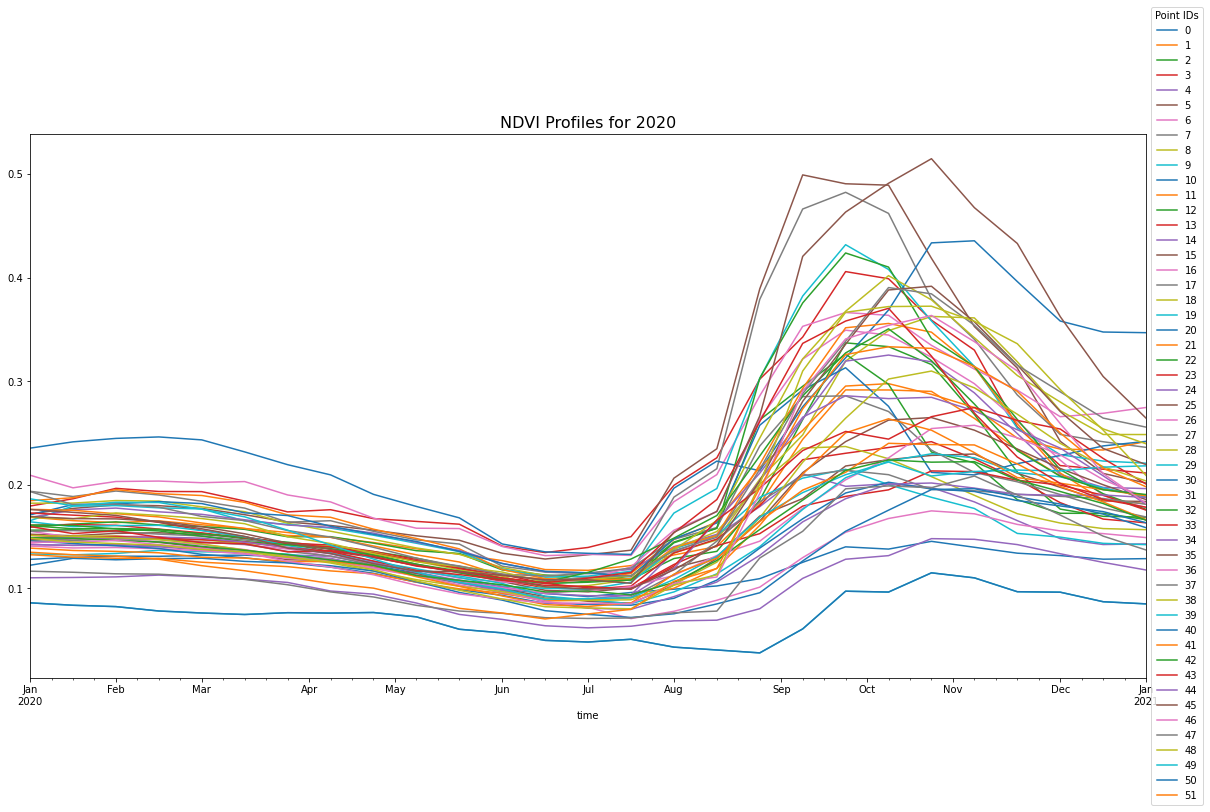

In [10]:
# Plot the NDVI profile for each point.
fig, ax = plt.subplots(figsize=(20, 10), facecolor="white")
for column in ndvi_time_series_df.columns:
    ndvi_time_series_df.loc[:,column].plot(ax=ax)


ax.legend(title="Point IDs", bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.set_title(f"NDVI Profiles for {time}",  fontsize=16);
fig.savefig(f"{output_dir}/{file_name}_ndvi_profiles_{time}.png")

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [11]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [12]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-06-30'